# Chart data from MCS

## Data from Unknown.csv

### Preprocess

<font size = 4>
   
All lines in **Unknown.csv** are saved in 1 column. Before being deploied, they need to be:
    
    1) converted into string
    2) split by delimiter
    3) converted into numpy.array
    
However, in original Unknown.csv, the first lines contains information of:
    
    1st line: recording information (e.g. recorded time)
    2nd line: number of frames
    3rd line: names of links (position and angle)
    4th line: axis (X,Y,Z)
    5th line: unit (mm, degree)
    
which have different columns after being split and converted into numpy.array, compared with the rest of lines, i.e. recorded values. This situation causes it difficult to index and slice with both **numpy** and **pandas**. As a result, before loading **Unknown.csv**, firstly delete the first lines inside except recorded values and save as Unknown.NoHead.csv.

</font>

### Extract data

<font size=4>
    
The direct reference of data is 3rd line in original .csv, but the number of colunms still differs. After detailed testing, the following results are obtained, which only contain information of position without angles. Note that the information below is from original .csv:
    
    frame;sub-frame;annotation;
    CenterOfGravity;;;
    LWristPositions;;;LWristAngles;;;LElbowPositions;;;LElbowAngles;;;LShoulderPositions;;;LShoulderAngles;;;
    RWristPositions;;;RWristAngles;;;RElbowPositions;;;RElbowAngles;;;RShoulderPositions;;;RShoulderAngles;;;
    LToePositions;;;LToeAngles;;;LAnklePositions;;;LAnkleAngles;;;LKneePositions;;;LKneeAngles;;;LHipPositions;;;LHipAngles;;;
    RToePositions;;;RToeAngles;;;RAnklePositions;;;RAnkleAngles;;;RKneePositions;;;RKneeAngles;;;RHipPositions;;;RHipAngles;;;
    LClaviclePositions;;;LClavicleAngles;;;LHandEndPositions;;;LHandEndAngles;;;LToesEndPositions;;;LToesEndAngles;;;
    RClaviclePositions;;;RClavicleAngles;;;RHandEndPositions;;;RHandEndAngles;;;RToesEndPositions;;;RToesEndAngles;;;
    Spine1Positions;;;Spine1Angles;;;Spine2Positions;;;Spine2Angles;;;Spine3Positions;;;Spine3Angles;;;Spine4Positions;;;Spine4Angles;;;Spine5Positions;;;Spine5Angles;;;
    NeckPosition;;;NeckAngles;;;HeadPositions;;;HeadAngles;;;HeadEndPositions;;;HeadEndRotations;;

And the index for extracting these data is recorded in next sector inside the codes, which is in function **get_prepared()**.
    
</font>

### Deploy data

<font size=4>
    
After extracting data from original .csv, new index for **x_pos**, **y_pos**, **z_pos** is:
    
    0:LWrist 1:LElbow 2:LShoulder
    3:RWrist 4:RElbow 5:RShoulder
    6:LToe 7:LAnkle 8:LKnee 9:LHip
    10:RToe 11:RAnkle 12:RKnee 13:RHip
    14:LClavicle 15:LHandEnd 16:LToesEnd
    17:RClavicle 18:RHandEnd 19:RToesEnd
    20:spine1 21:spine2 22:spine3 23:spine4 24:spine5 25:head 
    
Therefore, the links connected with these joints are defined **in order**:
    
    index 15,0,1,2,14: left arm
    index 18,3,4,5,17: right arm
    index 16,6,7,8,9: left leg
    index 19,10,11,12,13: right leg
    index 20,21,22,23,24: spine
    index 25: head

In [20]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime as dt
from itertools import count
%matplotlib inline
# to rotate 3D plot interactively
%matplotlib notebook

frames = count()

#################################
###### calculate distances ######
#################################
        
def calc_dist(coords,joints):
    dist_sum = np.zeros(coords[0].shape[0])
    for i,j in zip(joints[:-1],joints[1:]):
        dist_sum += np.sqrt((coords[0][:,i] - coords[0][:,j])**2 + (coords[1][:,i] - coords[1][:,j])**2 + (coords[2][:,i] - coords[2][:,j])**2)
    return dist_sum
    
def calc_distances_timeline(coords,joints_dict):
    dist_time = []
    for links,joints in joints_dict.items():
        dist_time.append(calc_dist(coords,joints))
    return dist_time

##############################
###### plot links in 3D ######
##############################

def connect(frame,ax,joints):
    idx_lst = [[],[],[]]
    for i in joints:
        idx_lst[0].append(frame[0][i])
        idx_lst[1].append(frame[1][i])
        idx_lst[2].append(frame[2][i])
        ax.plot(idx_lst[0], idx_lst[1], idx_lst[2], color='red')

def connect_with_lines(frame,ax,joints_dict):
    for links,joints in joints_dict.items():
        connect(frame,ax,joints)
        
#######################################
###### plot distance-lines in 2D ######
#######################################

def plot_distances(dist_time,frame_id,ax):
    for joints in dist_time:
        ax.plot(np.arange(frame_id),dist_time[joints][:frame_id+1])

#########################################################
###### get coordinates, distances, and joints list ######
#########################################################

def get_ori_data(path,save):
    
    csv_df = pd.read_csv(path ,header=None, delimiter=';',low_memory=False)
    csv_np = csv_df.to_numpy()
    csv_np = csv_np.astype(np.float32)
    csv_np = csv_np / 1000.0 # mm -> m
    output_path = './Dataset_Proposal'

    # index in coords: x_pos, y_pos, z_pos:
    # original coordinates are different in y and z, so reserve them, both cog and other coordinates
    cog = csv_np[:,3:6]
    cog[:,[2,1]] = cog[:,[1,2]]
    x_pos_ori = csv_np[:,[6,12,18,24,30,36,42,48,54,60,66,72,78,84,90,96,102,108,114,120,126,132,138,144,150,168]]
    z_pos_ori = csv_np[:,[7,13,19,25,31,37,43,49,55,61,67,73,79,85,91,97,103,109,115,121,127,133,139,145,151,169]]
    y_pos_ori = csv_np[:,[8,14,20,26,32,38,44,50,56,62,68,74,80,86,92,98,104,110,116,122,128,134,140,146,152,170]]
    print(f'x_pos shape: {x_pos_ori.shape}')
#     print(f'contend inside x_pos: {x_pos_ori[0]}')
    
    # save the original position vectors into csv, or not
    if save == 'yes':
        num_row = x_pos_ori.shape[0]
        num_col = x_pos_ori.shape[1] * 3 + 3
        output_df = np.zeros((num_row,num_col))
        for frame,(C,X,Y,Z) in enumerate(zip(cog,x_pos_ori,y_pos_ori,z_pos_ori)):
            output_df[frame,0:3] = C # center of gravity
            output_df[frame,3::3] = X # x position
            output_df[frame,4::3] = Y # y position
            output_df[frame,5::3] = Z # z position
        df = pd.DataFrame(output_df)
        df.to_csv(os.path.join(output_path,'coordinates_yz.csv'),index=False,header=False)
    
    return cog,x_pos_ori,y_pos_ori,z_pos_ori
    
def get_prepared(path):

    cog,x_pos_ori,y_pos_ori,z_pos_ori = get_ori_data(path=path,save='no')
    coords_ori = [x_pos_ori,y_pos_ori,z_pos_ori]
    
    x_pos_withoutCOG = x_pos_ori-np.expand_dims(cog[:,0],axis=1)
    y_pos_withoutCOG = y_pos_ori-np.expand_dims(cog[:,1],axis=1)
    z_pos_withoutCOG = z_pos_ori-np.expand_dims(cog[:,2],axis=1)
    coords_withoutCOG = [x_pos_withoutCOG,y_pos_withoutCOG,z_pos_withoutCOG]
    
    x_pos_withoutCOG_bias = x_pos_withoutCOG - np.amin(x_pos_withoutCOG)
    y_pos_withoutCOG_bias = y_pos_withoutCOG - np.amin(y_pos_withoutCOG)
    z_pos_withoutCOG_bias = z_pos_withoutCOG - np.amin(z_pos_withoutCOG)
    coords_withoutCOG_bias = [x_pos_withoutCOG_bias,y_pos_withoutCOG_bias,z_pos_withoutCOG_bias]
    
    # joints list
    joints_dict = {'left arm': [15,0,1,2,14,24],
                  'right arm': [18,3,4,5,17,24],
                  'left leg': [16,6,7,8,9,20],
                  'right leg': [19,10,11,12,13,20],
                  'spine': [20,21,22,23,24,25]
                 }
    
    # change of distances
    dist_time = calc_distances_timeline(coords_ori,joints_dict)
    
    return coords_ori,coords_withoutCOG,coords_withoutCOG_bias,dist_time,joints_dict

##################################
###### plot with each frame ######
##################################

def calc_axis_limit(coords):
    x_high, x_low = int(np.ceil(coords[0].max()*1000/200.0))*200, int(np.floor(coords[0].min()*1000/200.0))*200
    y_high, y_low = int(np.ceil(coords[1].max()*1000/200.0))*200, int(np.floor(coords[1].min()*1000/200.0))*200
    z_high, z_low = int(np.ceil(coords[2].max()*1000/200.0))*200, int(np.floor(coords[2].min()*1000/200.0))*200
    return [[x_high, x_low],[y_high, y_low],[z_high, z_low]]

def prepare_ax(coords,ax,limits):
    # axis label
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # axis limit
    x_high, x_low = limits[0][0],limits[0][1]
    y_high, y_low = limits[1][0],limits[1][1]
    z_high, z_low = limits[2][0],limits[2][1]
    ax.axes.set_xlim3d(left=x_low/1000.0, right=x_high/1000.0) 
    ax.axes.set_ylim3d(bottom=y_low/1000.0, top=y_high/1000.0)
    ax.axes.set_zlim3d(bottom=z_low/1000.0, top=z_high/1000.0)
    # axis scale
    ax.set_xticks(list(i/1000.0 for i in range(x_low,x_high,200)))
    ax.set_yticks(list(i/1000.0 for i in range(y_low,y_high,200)))
    ax.set_zticks(list(i/1000.0 for i in range(z_low,z_high,200)))
    # axis aspect ratio
    ax.set_box_aspect(aspect = (x_high-x_low,y_high-y_low,z_high-z_low))

def plot_func_3d(frame_id,ax,coords,limits,title):
    # plot links in 3D 
    ax.cla()
    current_frame = [coords[0][frame_id], coords[1][frame_id], coords[2][frame_id]] # x_pos,z_pos,y_pos
    prepare_ax(coords,ax,limits)
    ax.set_title(title)
    ax.scatter3D(current_frame[0], current_frame[1], current_frame[2], c='steelblue', marker='<')
    connect_with_lines(current_frame,ax,joints_dict)

def plot_func_2d(frame_id,ax,title):
    # plot distance-lines in 2D
    # attentions:
    #    don't call ax.cla() for 2D projection, because previous plot is needed
    ax.set_title(title)
    x = np.arange(frame_id)
    for idx,dist_plot in enumerate(dist_plots):
        dist_plot.set_data(x, dist_time[idx][:frame_id])

### Save coordinates into ./Dataset_Proposal/coordinates.csv

In [25]:
cog,x_pos_ori,y_pos_ori,z_pos_ori = get_ori_data(path=path,save='yes')

x_pos shape: (18000, 26)


### Get general parameters

In [21]:
path = 'NoHead_CSV/unknown.NoHead.csv'
coords_ori,coords_withoutCOG,coords_withoutCOG_bias,dist_time,joints_dict = get_prepared(path)
N_frames = 600

x_pos shape: (18000, 26)


### Plot original coordinates

<IPython.core.display.Javascript object>


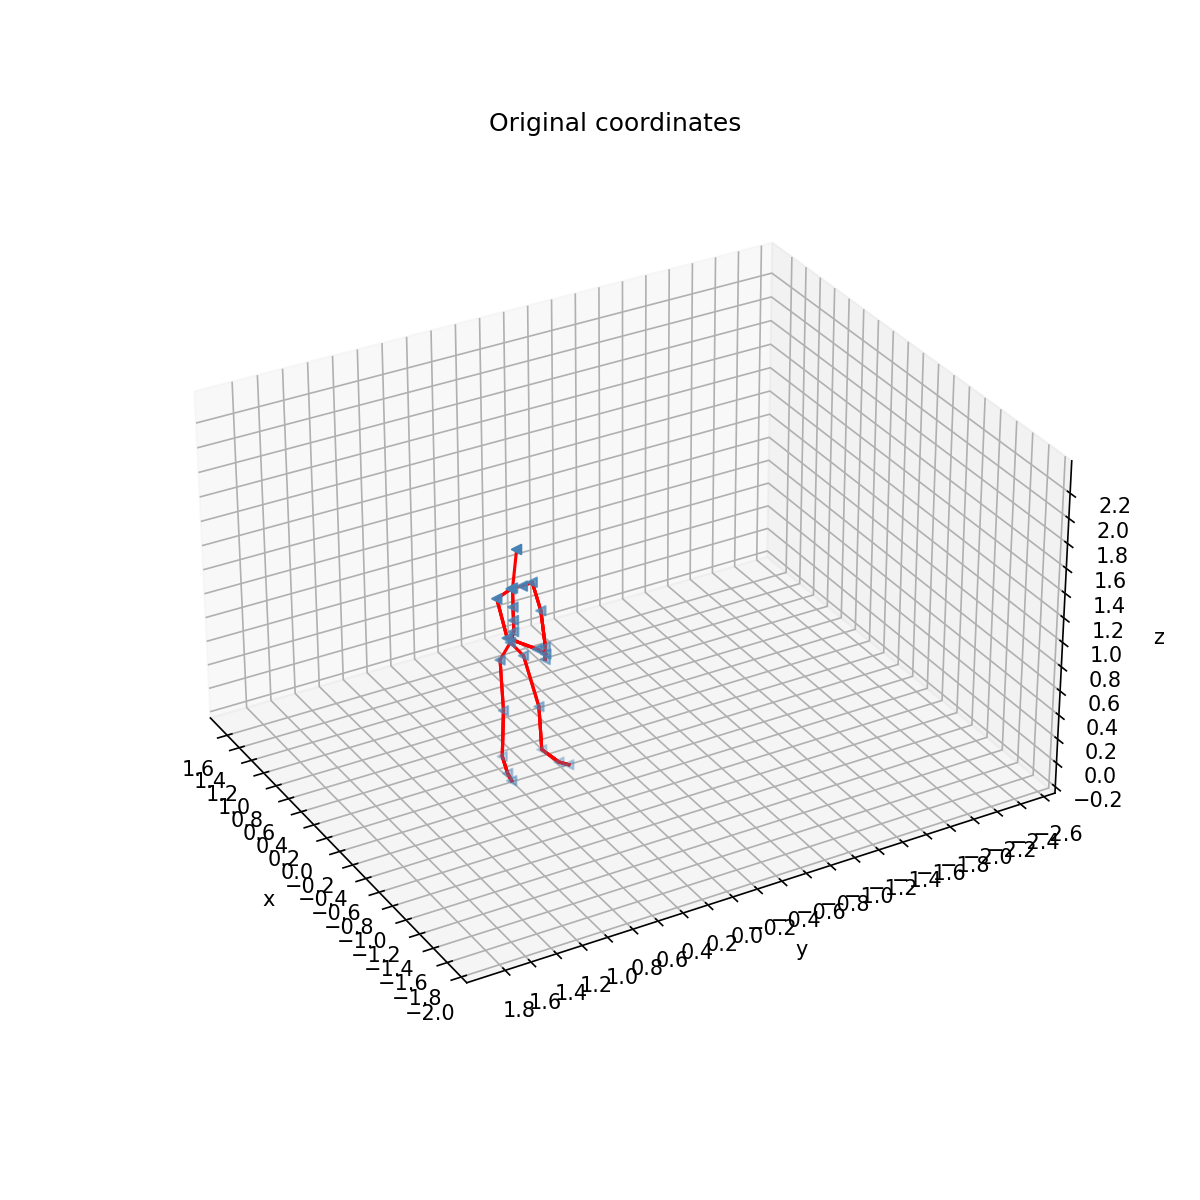

In [22]:
fig1 = plt.figure(figsize=(8,8))
fig1.tight_layout()
# plot links in 3D 
ax1 = fig1.add_subplot(projection='3d')
ax1.view_init(30, 150)
# args
limits_1 = calc_axis_limit(coords_ori) # (x_high, x_low), (y_high, y_low), (z_high, z_low)
title_1 = 'Original coordinates'
# animation
ani1 = animation.FuncAnimation(fig1,plot_func_3d,frames=N_frames,fargs=(ax1,coords_ori,limits_1,title_1),interval=17)
plt.show()
# # save .gif
# writergif = animation.PillowWriter(fps=30) 
# ani1.save(f"{dt.now().strftime('%d-%h-%H-%M')}_anim_1.gif", writer=writergif)

<IPython.core.display.Javascript object>


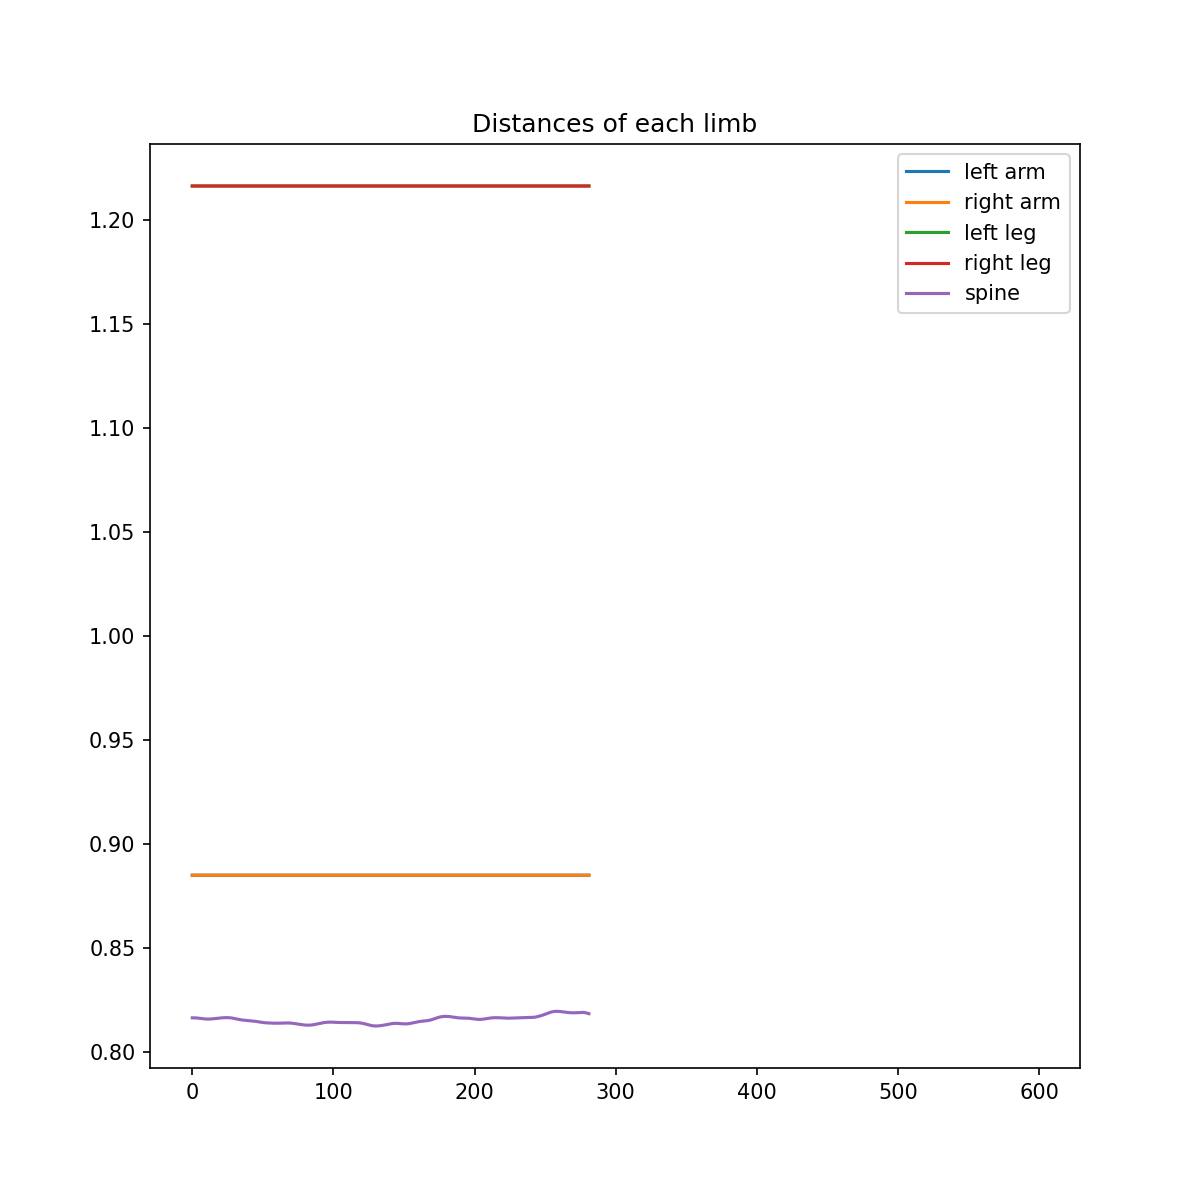

In [10]:
fig2 = plt.figure(figsize=(8,8))
fig2.tight_layout()
# plot distance-lines in 2D
ax2 = fig2.add_subplot()
x = np.arange(N_frames)
dist_plots = [ax2.plot(x, dist_time[idx][:N_frames],label=f'{links}')[0] for idx,(links,joints) in enumerate(joints_dict.items())]
plt.legend()
title_2 = 'Distances of each limb'
# dist_plots = [ax2.plot(x, dist_time[2][:N_frames])[0]]
# animation
ani2 = animation.FuncAnimation(fig2,plot_func_2d,frames=N_frames,fargs=(ax2,title_2),interval=17)
plt.show()
# # save .gif
# writergif = animation.PillowWriter(fps=30) 
# ani2.save(f"{dt.now().strftime('%d-%h-%H-%M')}_anim_2.gif", writer=writergif)

<IPython.core.display.Javascript object>


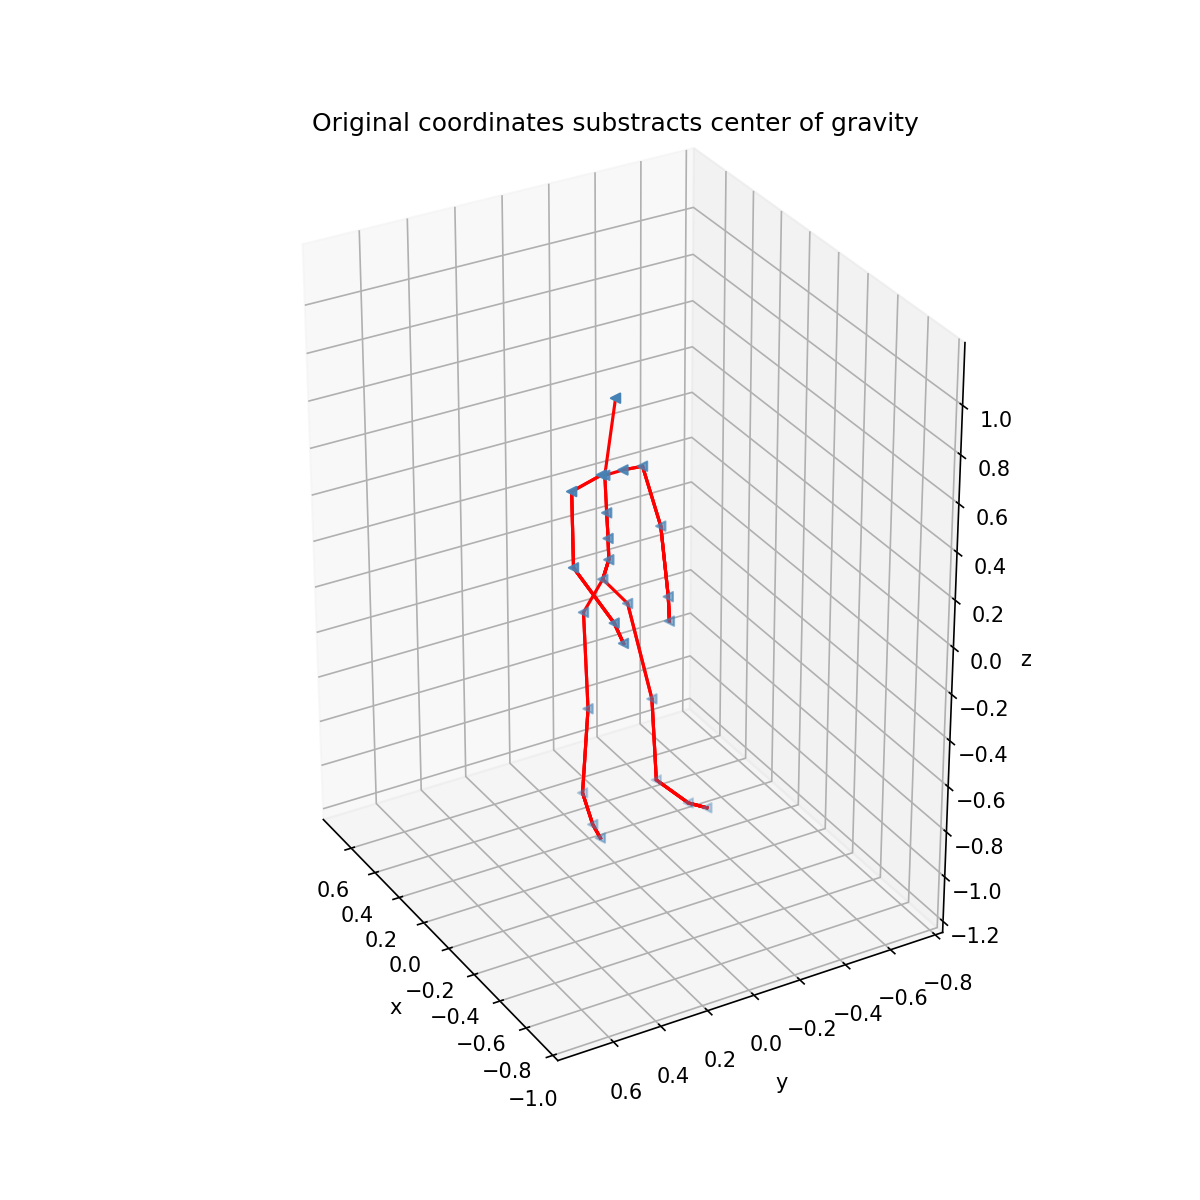

In [23]:
fig3 = plt.figure(figsize=(8,8))
fig3.tight_layout()
# plot links in 3D 
ax3 = fig3.add_subplot(projection='3d')
ax3.view_init(30, 150)
# args
limits_3 = calc_axis_limit(coords_withoutCOG) # (x_high, x_low), (y_high, y_low), (z_high, z_low)
title_3 = 'Original coordinates substracts center of gravity'
# animation
ani3 = animation.FuncAnimation(fig3,plot_func_3d,frames=N_frames,fargs=(ax3,coords_withoutCOG,limits_3,title_3),interval=17)
plt.show()
# # save .gif
# writergif = animation.PillowWriter(fps=30) 
# ani3.save(f"{dt.now().strftime('%d-%h-%H-%M')}_anim_3.gif", writer=writergif)

<IPython.core.display.Javascript object>


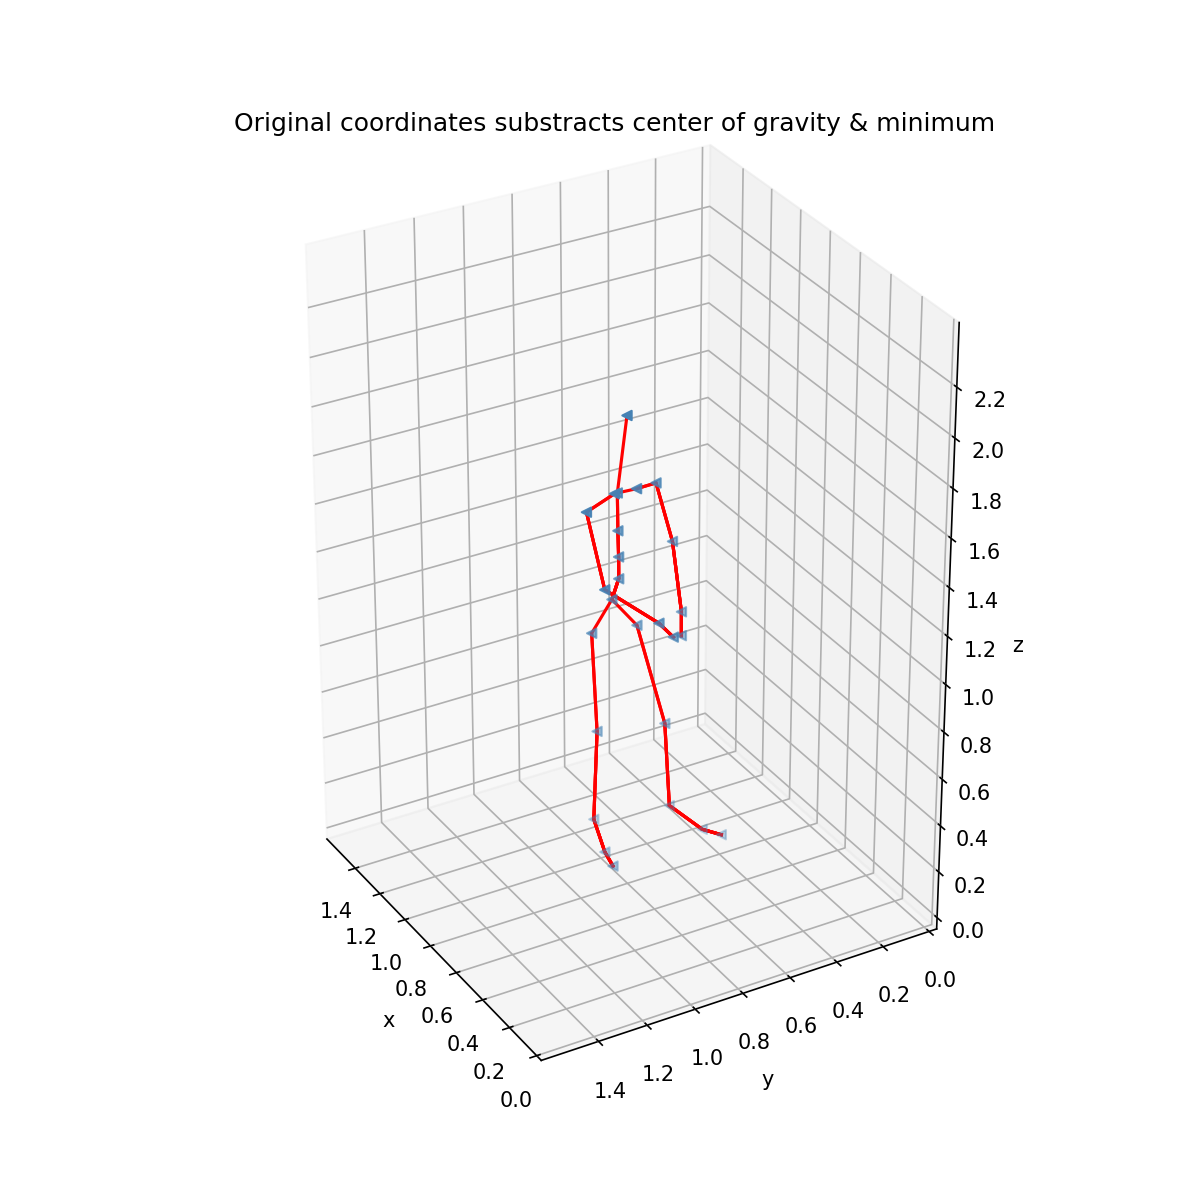

In [24]:
fig4 = plt.figure(figsize=(8,8))
fig4.tight_layout()
# plot links in 3D 
ax4 = fig4.add_subplot(projection='3d')
ax4.view_init(30, 150)
# args
limits_4 = calc_axis_limit(coords_withoutCOG_bias) # (x_high, x_low), (y_high, y_low), (z_high, z_low)
title_4 = 'Original coordinates substracts center of gravity & minimum'
# animation
ani4 = animation.FuncAnimation(fig4,plot_func_3d,frames=N_frames,fargs=(ax4,coords_withoutCOG_bias,limits_4,title_4),interval=17)
plt.show()
# # save .gif
# writergif = animation.PillowWriter(fps=30) 
# ani4.save(f"{dt.now().strftime('%d-%h-%H-%M')}_anim_4.gif", writer=writergif)

## Reference
<font size = 4>
matplotlib.animation.FuncAnimation:

https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation

Example of FuncAnimation:

https://matplotlib.org/stable/gallery/animation/random_walk.html